# Speaker Modeling with Gaussian Mixture Model (GMM)

## Libraries Import

In [1]:
import os
import re

import librosa
import pandas as pd
import numpy as np
import seaborn
from sklearn.metrics import accuracy_score, det_curve
from sklearn.mixture import GaussianMixture
from sklearn.metrics import DetCurveDisplay
import matplotlib.pyplot as pyplot

## Configuration

In [2]:
DATASET_FOLDER = "datasets/voice_toy/"
TEST_FOLDER_NAME = "test"
MFCC_COUNT = 12
MIXTURES_COUNT = 64
EVALUATED_SPEAKER = 0
SCORE_THRESHOLD = 0.7

## Dataset Creation

An empty dataset is created by defining the columns:
- speaker identifier;
- boolean indicating if the entry is for training or for test;
- `MFCC_COUNT` Mel-frequency cepstrum coefficients (MFCC);
- `MFCC_COUNT` delta MFCC;
- `MFCC_COUNT` delta delta MFCC;
- energy;
- delta energy; and
- delta delta energy.

For each frame from each file in the dataset, the mentioned features are extracted and placed as a new row in the DataFrame.

In [3]:
# Create the names of the columns
column_names = ["speaker", "is_test"]
column_names.extend(["mfcc_" + str(index) for index in range(MFCC_COUNT)])
column_names.extend(["delta_mfcc_" + str(index) for index in range(MFCC_COUNT)])
column_names.extend(["delta_delta_mfcc_" + str(index) for index in range(MFCC_COUNT)])
column_names.append("energy")
column_names.append("delta_energy")
column_names.append("delta_delta_energy")

# Create the DataFrame
speakers_df = pd.DataFrame(columns=column_names)

In [4]:
def extract_features(filename: str) -> np.matrix:
    y, sample_rate = librosa.load(filename)

    mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=MFCC_COUNT)
    delta_mfcc = librosa.feature.delta(mfcc, axis=1)
    delta_delta_mfcc = librosa.feature.delta(delta_mfcc, axis=1)
    rms = librosa.feature.rms(y)
    delta_rms = librosa.feature.delta(rms, axis=1)
    delta_delta_rms = librosa.feature.delta(rms, axis=1)

    features = mfcc
    features = np.concatenate((features, delta_mfcc))
    features = np.concatenate((features, delta_delta_mfcc))
    features = np.concatenate((features, rms))
    features = np.concatenate((features, delta_rms))
    features = np.concatenate((features, delta_delta_rms))
    
    return np.transpose(features)

In [5]:
for subdir, dirs, files in os.walk(DATASET_FOLDER):
    for current_filename in files:
        # Extract the file features
        full_path = os.path.join(subdir, current_filename)
        features = extract_features(full_path)

        # Add speaker information
        speaker = current_filename.split("_")[0]
        is_test = TEST_FOLDER_NAME in subdir
        speaker_column = np.full(shape=(features.shape[0], 1), fill_value=speaker, dtype=np.object)
        type_column = np.full(shape=(features.shape[0], 1), fill_value=is_test, dtype=np.object)
        features = np.hstack((speaker_column, type_column, features))
        print("[+] The features of {} frames of the file '{}' were extracted.".format(len(features), full_path))

        # Add a new row into the DataFrame
        features_df = pd.DataFrame(features, columns=column_names)
        speakers_df = speakers_df.append(features_df, ignore_index=True)

[+] The features of 213 frames of the file 'dataset/dev/f2/f2_0749030227.wav' were extracted.
[+] The features of 212 frames of the file 'dataset/dev/f2/f2_0741277243.wav' were extracted.
[+] The features of 29 frames of the file 'dataset/dev/f2/f2_URGENTA.6.wav' were extracted.
[+] The features of 30 frames of the file 'dataset/dev/f2/f2_APELEAZA.7.wav' were extracted.
[+] The features of 22 frames of the file 'dataset/dev/f2/f2_4.wav' were extracted.
[+] The features of 213 frames of the file 'dataset/dev/f2/f2_0728039567.wav' were extracted.
[+] The features of 203 frames of the file 'dataset/dev/f2/f2_0742303767.wav' were extracted.
[+] The features of 17 frames of the file 'dataset/dev/f2/f2_9.wav' were extracted.
[+] The features of 231 frames of the file 'dataset/dev/f2/f2_0746701655.wav' were extracted.
[+] The features of 29 frames of the file 'dataset/dev/f2/f2_7.wav' were extracted.
[+] The features of 31 frames of the file 'dataset/dev/f2/f2_STELUTA.6.wav' were extracted.
[

In [6]:
print("[+] There are {} entries in the DataFrame.".format(len(speakers_df)))

[+] There are 76014 entries in the DataFrame.


## Models Training

Further, the dataset is filtered to retrieve the training samples for each speaker. These are fed as input for a Gaussian mixture model with `MIXTURES_COUNT` components.

After training each model, matrices containing the means and the deviations for each component mixture are created.

In [7]:
speakers = np.sort(speakers_df["speaker"].unique())
models = []
for speaker in speakers:
    # Filter by the current speaker
    speaker_df = speakers_df[(speakers_df["speaker"] == speaker) & (speakers_df["is_test"] == False)]
    dropped_speaker_df = speaker_df.drop(["speaker", "is_test"], axis = 1)

    # Train a model
    mixture = GaussianMixture(n_components=MIXTURES_COUNT, random_state=0).fit(dropped_speaker_df)
    models.append(mixture)

In [8]:
mixtures_parameters = []
for model in models:
    # Get the standard deviation
    deviation = [np.sqrt(np.trace(model.covariances_[i]) / MIXTURES_COUNT) for i in range(0, MIXTURES_COUNT)]

    # Create a matrix with all details of the mixtures
    parameters = np.hstack((model.means_, np.array([deviation]).T))
    mixtures_parameters.append(parameters)

## Multiple Users Identification System Evaluation

The first executed evaluation is for an identification system, which will try to recognize the speaker based on the score returned by each trained model. The assigned label is the one from the model with the biggest score.

In [10]:
test_df = speakers_df[speakers_df["is_test"] == True]
dropped_test_df = test_df.drop(["speaker", "is_test"], axis = 1)

In [11]:
scores = [model.score_samples(dropped_test_df) for model in models]
y_pred = np.argmax(scores, axis=0)

In [12]:
speakers_list = list(speakers)
y_real = [speakers_list.index(speaker_id) for speaker_id in test_df["speaker"].values]

In [13]:
score = accuracy_score(y_real, y_pred)
print("[+] The accuracy of the model is {:.4f}.".format(score))

[+] The accuracy of the model is 0.9466.


## Models Exploration

Before trying to evaluate individually each model, the scores returned by the predictions for the authorized users are scaled into the interval `[0, 1]` and plotted. In this manner, we can choose a threshold above each a predicted score is considered to be for an unauthorized user.

In [14]:
speaker = speakers[EVALUATED_SPEAKER]
speaker_df = speakers_df[(speakers_df["speaker"] == speaker) & (speakers_df["is_test"] == False)]
dropped_speaker_df = speaker_df.drop(["speaker", "is_test"], axis = 1)

In [15]:
scores = model.score_samples(dropped_speaker_df)

In [16]:
def scale(array: np.array) -> np.array:
    return (array - np.min(array))/(np.max(array) - np.min(array))

[]

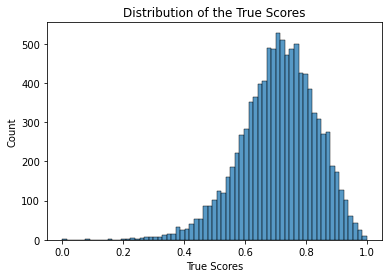

In [17]:
scaled_scores = scale(scores)
seaborn.histplot(scaled_scores)
pyplot.xlabel("True Scores")
pyplot.title("Distribution of the True Scores")
pyplot.plot()

## Single Users Identification System Evaluation

For the chosen model, predictions are made for the whole test dataset. As the above approach, the returned scores are scaled into the interval `[0, 1]`.

For computing the false acceptance rate (FAR) and the false recognition rate (FRR), the scaled score was binarized considering the threshold deduced from the previous section. So, FAR is computed by dividing the number of accepted unauthorized users (that are not the user for whom the model was created, namely not `EVALUATED_SPEAKER`) by the number of unauthorized users in the test dataset. Also, the FRR is the division between the number of rejected authorized users (that are the user for whom the model was created, namely `EVALUATED_SPEAKER`) and the number of authorized users in the test dataset.

Before plotting the DET curve, the labels were binarized relatively to the authorized user. In this manner, the samples from the dataset produced by him are assigned with `1` and the others with `0`. Next, the false-positive rates (FPR) and the false negative rates (FNR) are computed and fed into a plotting function.

In [18]:
model = models[EVALUATED_SPEAKER]
scores = model.score_samples(dropped_test_df)
scores = scale(scores)

In [19]:
y_pred = [int(score > SCORE_THRESHOLD) for score in scores]

is_legit = [current_speaker == speaker for current_speaker in test_df["speaker"].values]
legits = np.sum(is_legit)
impostors = len(is_legit) - legits

impostors_accepted = 0
legit_rejected = 0
for y, legit in zip(y_pred, is_legit):
    if (not legit and y == EVALUATED_SPEAKER):
        impostors_accepted += 1
    if (legit and y != EVALUATED_SPEAKER):
        legit_rejected += 1

far = impostors_accepted / impostors
frr = legit_rejected / legits
print("[+] FAR is {}.".format(far))
print("[+] FRR is {}.".format(frr))

[+] FAR is 0.07890144905545861.
[+] FRR is 1.0.


In [20]:
y_real_relative = [int(y == EVALUATED_SPEAKER) for y in y_real]

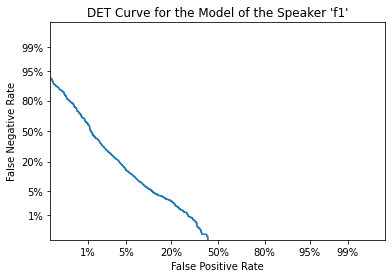

In [22]:
fpr, fnr, thresholds = det_curve(y_real_relative, scores)
display = DetCurveDisplay(fpr=fpr, fnr=fnr)
display.plot()
pyplot.title("DET Curve for the Model of the Speaker '{}'".format(speakers[EVALUATED_SPEAKER]))
pyplot.show()